Seasons covered: 8, total rounds: 149


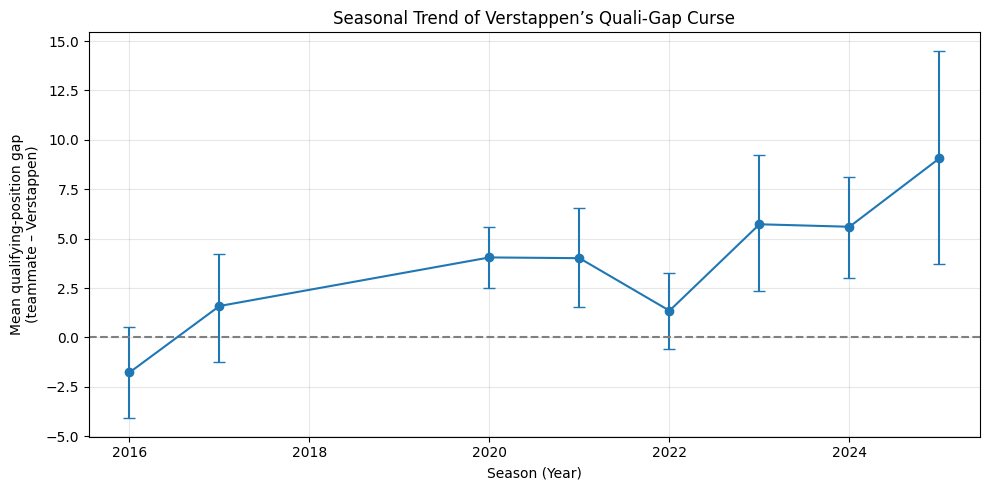

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma, norm

df = pd.read_csv("ALLTEAMSQvFDetail2016.csv")
df = df.rename(columns={
    'gridPos': 'qualifying_position',
    'raceResult': 'finishing_position'
})
df['qualifying_position'] = pd.to_numeric(df['qualifying_position'], errors='coerce')
df['finishing_position']  = pd.to_numeric(df['finishing_position'],  errors='coerce')
max_finish = int(df['finishing_position'].max(skipna=True))
df['finishing_position'] = df['finishing_position'].fillna(max_finish + 1)

lead  = 'Max Verstappen'
team_key = 'Red Bull'

records = []
sub = df[df['Team'].str.contains(team_key, case=False, na=False)]
for (year, race), grp in sub.groupby(['Year','raceName']):
    drivers = grp['Driver'].unique()
    if lead in drivers and len(drivers)==2:
        g      = grp.set_index('Driver')
        q_lead = g.at[lead, 'qualifying_position']
        mate   = [d for d in drivers if d != lead][0]
        q_mat  = g.at[mate,'qualifying_position']
        records.append({
            'Year': year,
            'qual_gap': q_mat - q_lead
        })

df_ver = pd.DataFrame(records)
df_ver = df_ver.sort_values('Year').reset_index(drop=True)
print(f"Seasons covered: {df_ver['Year'].nunique()}, total rounds: {len(df_ver)}")
mu0, tau02 = 0.0, 100.0
alpha0, beta0 = 1.0, 1.0

nsamps = 2000
years  = sorted(df_ver['Year'].unique())
out = []

for yr in years:
    x = df_ver.loc[df_ver['Year']==yr, 'qual_gap'].values
    n = x.size
    xbar = x.mean()
    S = np.sum((x - xbar)**2)
    kappa_n = 1.0 + n
    mu_n    = (1.0*mu0 + n*xbar) / kappa_n
    alpha_n = alpha0 + n/2
    beta_n  = beta0 + 0.5*S + (1.0*n*(xbar-mu0)**2)/(2*kappa_n)
    sig2 = invgamma.rvs(a=alpha_n, scale=beta_n, size=nsamps)
    mus  = norm.rvs(loc=mu_n, scale=np.sqrt(sig2/kappa_n))
    mean_post = mus.mean()
    ci_low, ci_high = np.percentile(mus, [2.5, 97.5])
    out.append({
        'Year': yr,
        'n_rounds': n,
        'mean': mean_post,
        'ci_lower': ci_low,
        'ci_upper': ci_high
    })

trend = pd.DataFrame(out)

plt.figure(figsize=(10,5))
plt.errorbar(
    trend['Year'], trend['mean'],
    yerr=[trend['mean']-trend['ci_lower'], trend['ci_upper']-trend['mean']],
    fmt='o-', capsize=4
)
plt.axhline(0, color='grey', linestyle='--')
plt.xlabel('Season (Year)')
plt.ylabel('Mean qualifying-position gap\n(teammate – Verstappen)')
plt.title('Seasonal Trend of Verstappen’s Quali-Gap Curse')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
